# Long Text Classification ------ Longformer

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os
path="/content/drive/My Drive/MIMIC"

os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


['caml-mimic',
 'Multi-Filter-Residual-Convolutional-Neural-Network',
 'LAAT',
 'LAAT_Run.ipynb',
 'CALM_RUN.ipynb',
 'Process_Data',
 'Find_MN.ipynb',
 'MResCNN_RUN_2.ipynb',
 'MResCNN_RUN.ipynb',
 'BERT_FineTune',
 'Transformer_MCP_4.ipynb',
 'Transformer_MCP_1.ipynb',
 'Bert-Chinese-Text-Classification-Pytorch',
 'Transformer_MCP_2.ipynb',
 'Transformer_MCP_3.ipynb']

In [2]:
# ! git clone https://github.com/allenai/longformer.git

In [3]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
import json

import torch
import transformers
from transformers import LongformerModel, LongformerTokenizer
from torch.utils.data import Dataset

import json
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

In [5]:
# Sections of config
# Defining some key variables that will be used later on in the training
MAX_LEN = 4000
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 16
LEARNING_RATE = 1e-04
batch_size = 1
start_epochs = 1
n_epochs = 5
valid_loss_min_input = np.Inf

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")

# 加载已有模型

In [6]:
def load_ckp(checkpoint_fpath, model, optimizer):

    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training

    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

def save_ckp(state, checkpoint_path):
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)


# DataSet Loader

In [7]:
#################################### prepare data ###############################
# load raw data
train_data = pd.read_csv('/content/drive/My Drive/MIMIC/caml-mimic/mimicdata/mimic3/train_50.csv')
test_data = pd.read_csv('/content/drive/My Drive/MIMIC/caml-mimic/mimicdata/mimic3/test_50.csv')

# 首先收集所有的 top 50 的标签，做成列表
top_50_list = []
top_50_code = pd.read_csv('/content/drive/My Drive/MIMIC/caml-mimic/mimicdata/mimic3/TOP_50_CODES.csv',header=None)
for index in range(len(top_50_code[0])):
  raw_info = top_50_code.iloc[index]
  top_50_list.append(raw_info[0])

# 讲一条病人的数据，转化为向量
def data_2_label(data_text,top_50_list):
  label = []
  labels = data_text.split(';')
  for element in top_50_list:
    if element in labels:
      label.append(1)
    else:
      label.append(0)
  return label

# 制作训练集
train_data_list = []
for index in range(len(train_data['LABELS'])):
  row_info = train_data.iloc[index]
  text = row_info[2]
  labels = data_2_label(row_info[3],top_50_list)
  train_data_list.append([text,labels])
  
train_data_df = pd.DataFrame(train_data_list)
train_data_df.columns = ["text", "labels"]

# 制作测试集
test_data_list = []
for index in range(len(test_data['LABELS'])):
  row_info = train_data.iloc[index]
  text = row_info[2]
  labels = data_2_label(row_info[3],top_50_list)
  test_data_list.append([text,labels])
  
test_data_df = pd.DataFrame(test_data_list)
test_data_df.columns = ["text", "labels"]



In [8]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.title = dataframe['text']
        self.targets = dataframe['labels']
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )

        ids = torch.tensor(inputs['input_ids'],dtype=torch.long)  # 将 input 中的词 encode,把一句话变为一个一维的tensor, 向量长度为max-length, 如果文本过段，用0填充。
        mask = torch.tensor(inputs['attention_mask'],dtype = torch.long)  # 用于 truncation
        token_type_ids = torch.tensor(inputs["token_type_ids"],dtype= torch.long)  # 第几句话
        global_attention_mask = torch.zeros(ids.shape, device=ids.device)  # 设置 global attention 
        global_attention_mask[0] = 1
        return {
            'ids': ids,  # 数据 text ，经过encoder后的结果
            'mask': mask,
            'token_type_ids': token_type_ids,
            'targets': torch.tensor(self.targets[index], dtype=torch.float),
            'global_attention_mask':global_attention_mask.to(device)
        }

In [9]:
train_data_df.shape

(8066, 2)

In [10]:
test_data_df.shape

(1729, 2)

In [19]:
# 准备数据集 
'''
train_data_df_small = train_data_df[:1000]

train_size = 0.8
train_dataset = train_data_df_small.sample(frac=train_size,random_state=200)
valid_dataset = train_data_df_small.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(train_data_df_small.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(valid_dataset.shape))
'''
training_set = CustomDataset(train_data_df[:8065], tokenizer, MAX_LEN)
validation_set = CustomDataset(test_data_df[:1725], tokenizer, MAX_LEN)

In [21]:
# 把数据集做成 batch_size 的形式
train_iter = torch.utils.data.DataLoader(training_set, batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(validation_set, batch_size)

# Model

In [13]:
# 微调 Longformer
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = LongformerModel.from_pretrained("allenai/longformer-base-4096")
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 50)

    def forward(self, ids, mask, token_type_ids,global_attention_mask):
        outputs = self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids,global_attention_mask=global_attention_mask) # (last hidden output, pooled_hidden_output)
        output_2 = self.l2( outputs.pooler_output )  # pooled_hidden_output , 池化后的 result
        output = self.l3(output_2)
        return output
        

In [14]:
model = BERTClass()
model.to(device)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0): LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (value_global): Linear(in_features=768

# Train + Evaluation 

In [15]:
def loss_fn(outputs, targets):
    #return torch.nn.BCEWithLogitsLoss()(outputs, targets)
    return torch.nn.functional.cross_entropy(outputs, targets)

# optimizer = torch.optim.Adam(params = model.parameters(), lr=LEARNING_RATE)
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
# optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE)


In [16]:
def get_roc_auc(val_targets,val_outputs):
  # Compute ROC curve and ROC area for each class
  n_classes = 50
  fpr = {}
  tpr = {}
  roc_auc = {}
  for i in range(n_classes):
    fpr_, tpr_, _ = roc_curve(val_targets[:, i], val_outputs[:, i])
    fpr[i] = fpr_.tolist()
    tpr[i] = tpr_.tolist()
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr_, tpr_, _ = roc_curve(val_targets.ravel(), val_outputs.ravel())
  fpr['micro'] = fpr_.tolist()
  tpr['micro'] = tpr_.tolist()
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Compute macro-average ROC curve and ROC area
  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
  # Finally average it and compute AUC
  mean_tpr /= n_classes
  fpr["macro"] = all_fpr.tolist()
  tpr["macro"] = mean_tpr.tolist()
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
  return fpr,tpr,roc_auc


def visulization(train_loss_list,val_loss_list,fpr,tpr,roc_auc):
  # Plot all ROC curves
  plt.figure()
  plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
  )

  plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
  ) 
  ''' # 暂时不打印50个label的ROC曲线
  colors = cycle(["aqua"]) # ["aqua", "darkorange", "cornflowerblue"]
  for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )
  '''
  plt.plot([0, 1], [0, 1], "k--", lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Some extension of Receiver operating characteristic to multiclass")
  plt.legend(loc="lower right")
  plt.show()

  #打印 train_loss , val_loss 
  plt.figure(figsize=(15, 12))
  plt.subplot(131)
  plt.plot(range(len(train_loss_list)), train_loss_list)
  plt.subplot(132)
  plt.plot(range(len(val_loss_list)), val_loss_list)
  plt.show()


In [17]:
# 训练函数 ： 训练部分；验证部分；可视化 + 保存函数 + 保存参数
def train_model(start_epochs,  n_epochs, valid_loss_min_input, training_loader, validation_loader, 
                model, optimizer, 
                checkpoint_path,
                model_name):

  # initialize tracker for minimum validation loss
  result = {}
  result['model name'] = model_name
  valid_loss_min = valid_loss_min_input 
  train_loss_list = []
  val_loss_list = []
  roc_macro_list = []
  roc_micro_list = []
  for epoch in range(start_epochs, n_epochs+1):
    result_per_epoch = {}
    val_targets = []
    val_outputs = []
    train_loss = 0
    valid_loss = 0

    ######################    
    # Train the model #
    ######################
    model.train()
    print('###############   Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        #print('yyy epoch', batch_idx)
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        global_attention_mask = data['global_attention_mask']

        outputs = model(ids, mask, token_type_ids ,global_attention_mask)  

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        #if batch_idx%5000==0:
         #   print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('before loss data in training', loss.item(), train_loss)
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        #print('after loss data in training', loss.item(), train_loss)

    print('Epoch {}: Training End'.format(epoch))
    print('Epoch {}: Validation Start'.format(epoch))
    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            global_attention_mask = data['global_attention_mask']

            outputs = model(ids, mask, token_type_ids,global_attention_mask)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.relu(outputs).cpu().detach().numpy().tolist())

      print('Epoch {}: Validation End'.format(epoch))
      # calculate average losses
      #print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      train_loss_list.append(train_loss)   # 记录训练损失函数
      val_loss_list.append(valid_loss)      # 记录验证损失函数
      # print training/validation statistics 
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
    #####################################
    ######### 记录结果，打印 ROC, 计算AUC，保存模型  #########
    #####################################
    val_targets = np.array(val_targets)
    val_outputs = np.array(val_outputs)
    fpr,tpr,roc_auc = get_roc_auc(val_targets,val_outputs) # 计算出 ROC_AUC 的值
    roc_macro_list.append(roc_auc['macro'])
    roc_micro_list.append(roc_auc['micro'])
    result_per_epoch['epoch'] = epoch
    result_per_epoch['train_loss_list'] = train_loss_list
    result_per_epoch['val_loss_list'] = val_loss_list
    result_per_epoch['roc_macro_list'] = roc_macro_list
    result_per_epoch['roc_micro_list'] = roc_micro_list
    result_per_epoch['fpr'] = fpr
    result_per_epoch['tpr'] = tpr
    result_per_epoch['roc_auc'] = roc_auc
    result['epoch '+str(epoch)] = result_per_epoch  # 最后把每一次迭代得到的结果保存到 result 里面

    #### 如果得到的模型 val loss 是目前最好成绩，那么我们就保存函数 + 可视化
    checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
      ## TODO: save the model if validation loss has decreased
    if valid_loss <= valid_loss_min:
      valid_loss_min = valid_loss
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
      # save checkpoint as best model
      save_ckp(checkpoint, checkpoint_path+'/checkpoint_epoch_'+ str(epoch) + '.pt' )
      visulization(train_loss_list,val_loss_list,fpr,tpr,roc_auc)
      # save the result : train loss, validation loss, auc_list, roc_curve
      # 最后把结果result 保存
      result_per_epoch_json = json.dumps(result_per_epoch,sort_keys=False, indent=4, separators=(',', ': '))
      f = open(checkpoint_path + '/result_epoch_'+ str(epoch) +'.json', 'w')
      f.write(result_per_epoch_json)

  #return model


###############   Epoch 1: Training Start   #############
Epoch 1: Training End
Epoch 1: Validation Start
Epoch 1: Validation End
Epoch: 1 	Avgerage Training Loss: 0.154664 	Average Validation Loss: 0.807745
Validation loss decreased (0.807745 --> 0.807745).  Saving model ...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/pytho

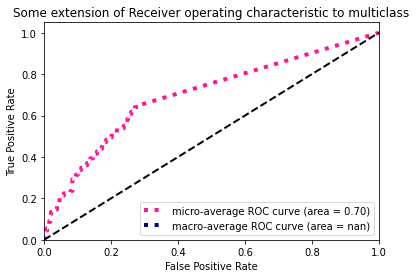

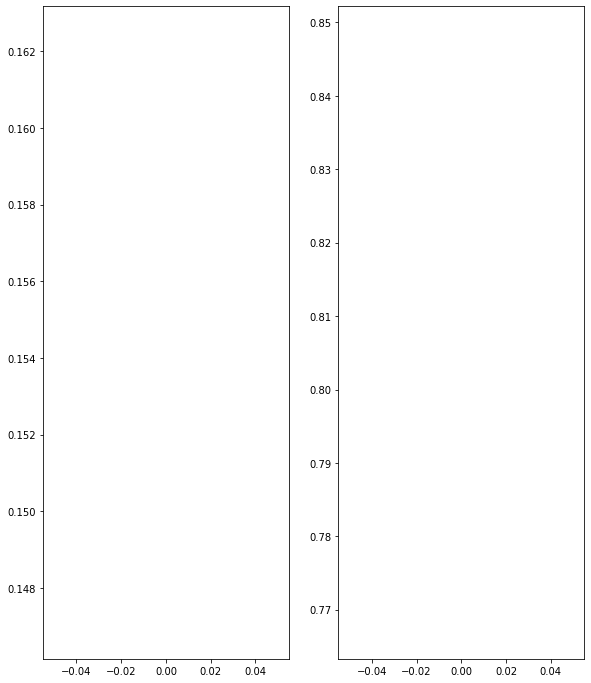

###############   Epoch 2: Training Start   #############
Epoch 2: Training End
Epoch 2: Validation Start
Epoch 2: Validation End
Epoch: 2 	Avgerage Training Loss: 0.151768 	Average Validation Loss: 0.808354
###############   Epoch 3: Training Start   #############


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/pytho

Epoch 3: Training End
Epoch 3: Validation Start
Epoch 3: Validation End
Epoch: 3 	Avgerage Training Loss: 0.150630 	Average Validation Loss: 0.805038
Validation loss decreased (0.805038 --> 0.805038).  Saving model ...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/pytho

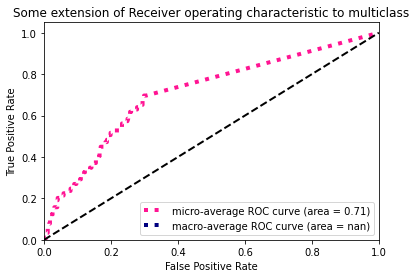

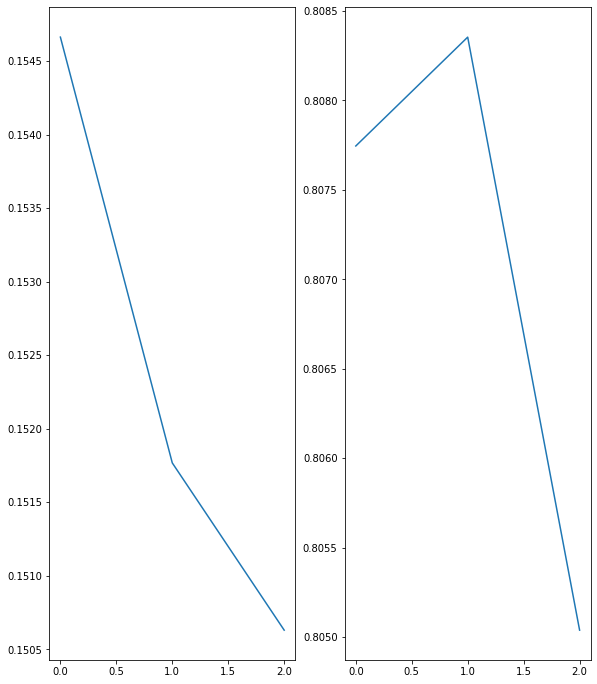

###############   Epoch 4: Training Start   #############
Epoch 4: Training End
Epoch 4: Validation Start
Epoch 4: Validation End
Epoch: 4 	Avgerage Training Loss: 0.150508 	Average Validation Loss: 0.811417
###############   Epoch 5: Training Start   #############


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/pytho

KeyboardInterrupt: ignored

In [18]:
checkpoint_path = '/content/drive/My Drive/MIMIC/BERT_FineTune/longformer'

model_name = 'longformer'

trained_model = train_model(start_epochs, n_epochs, valid_loss_min_input, train_iter, test_iter, 
                            model, optimizer,
                            checkpoint_path, 
                            model_name )


# Practice